# Multivariate Analysis - PCA

In this notebook we will perform an unsupervised *multivariate* exploratory analysis with principal component analysis (PCA) of the [AddNeuroMed](https://nyaspubs.onlinelibrary.wiley.com/doi/10.1111/j.1749-6632.2009.05064.x) dataset of Alzheimer's disease.

The notebook is divided in the following steps:

1) **Model fitting basics:** Fit PCA models to the dataset with different scaling options.

2) **Model Cross-validation and component selection:** Describe model cross-validation routines, and best practices for model performance benchmarking and parameter selection.

3) **Outlier detection and model interpretation:** Use PCA to explore the main trends in the dataset and detect potential outliers.
4) **Model Interpretation**


<br>

*Credits: This tutorial was originally created by Gonçalo Correia and was adapted by Lukas Kopecky and Frederico Soares in November/December 2023.*

## Preliminary Steps

### Installing Packages

First we need to install required packages and clone the files from the [GitHub Rpository](https://github.com/kopeckylukas/IPTC-chemometrics-tutorials-LCMS.git) using this we will use some BASH scripting. You can skip this step if you are running this tutorial locally on your system; we recommend you to use Anaconda to install the required packages instead and then clone the files from GitHub repository locally.

In [1]:
!pip install -q ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.8 MB/s eta 0:00:00


In [2]:
!pip install kneed

In [4]:
!git clone https://github.com/kopeckylukas/IPTC-chemometrics-tutorials-LCMS.git
%cd IPTC-chemometrics-tutorials-LCMS

fatal: destination path 'IPTC-chemometrics-tutorials-LCMS' already exists and is not an empty directory.
/content/IPTC-chemometrics-tutorials-LCMS


In [5]:
# NOTE: running this cell will result in an error and dependencies conflict.
# Move to next cell if the last line of the error message is "Successfully installed numpy-1.26.4 scipy-1.11.3"
# otherwise restart the runtime and RE-RUN the cell with pip install commented out

!pip install scipy==1.11.3 numpy==1.26.4

import scipy
import numpy as np


### Import Packages

Import all the packages and configure notebook plotting mode.

In [6]:
# NOTE: It is likely that running this line will result in an error. If this occur, re-run this cell again.

import numpy as np
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import DataConversionWarning

from pyChemometrics.ChemometricsPCA import ChemometricsPCA
from pyChemometrics.ChemometricsScaler import ChemometricsScaler
from pyChemometrics.plotting_utils import plotLoadings
from pyChemometrics.plotting_utils import _scatterplots


# Use to obtain same values as in the text
np.random.seed(350)

In [7]:
# Set the data conversion warnings to appear only once to avoid repetition during CV
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

The next cell sets up the figure display mode. The *notebook* mode allows interactive plotting.

In [ ]:
# Set the plot backend to support interactive plotting
# %matplotlib notebook

### Data import

We will now import the LC-MS data with the metadata (Y variables) and feature annotation for LC-MS.

Then we split the data into two parts:

**X** - LC-MS data matrix

**Y** - Metadata that will help with the interpretation of the PCA model (sex/gender in this instance)

**Y2** - Metadata that will help with the interpretation of the PCA model (age in this instance)

Then we extract the feature annotations:

**retention_times**, **mz_values** - annotation for the features of the rpos_x_matrix data

<br>

*NB - The dataset used in this tutorial has reduced features to speed up the model fitting proces. Full data available from [https://zenodo.org/doi/10.5281/zenodo.4053166](https://zenodo.org/doi/10.5281/zenodo.4053166). We recommend you to try to run the tutorial with the full dataset in your own time, or you can even try to run it using your own data.*

In [8]:
# Load the dataset
dementia_rpos_dataset = pd.read_csv("./data/Dementia U RPOS_combinedData.csv",delimiter=',')

# Inspect the dataset
dementia_rpos_dataset.head(10)

,Sample ID,Subject ID,SampleType,Age,Gender,50.3_72.0806m/z,215.75_77.0383m/z,47.38_80.0493m/z,133.09_81.0331m/z,45.8_81.0445m/z,...,221.5_1071.3596m/z,205.8_1073.9622m/z,205.79_1074.4635m/z,205.8_1074.9644m/z,89.98_1083.0771m/z,89.91_1089.0929m/z,333.45_1127.4218m/z,187.72_1153.8814m/z,283.65_1167.5044m/z,74.63_1175.3683m/z
0,LND.0063_U,LND.0063,Study Sample,82.0,Female,4279.391329,132812.07700,4506.074689,2720.562045,2868.745303,...,4085.265210,6732.657513,6347.939155,3902.831649,5798.323898,7964.330802,4796.908684,2165.982590,3846.940012,7223.434421
1,DCR00076_U,DCR00076,Study Sample,74.0,Male,3945.457625,138417.13090,1309.942294,1249.494055,3494.259023,...,11689.675430,5598.134302,5787.515322,3195.600251,5593.213256,7127.606038,217.280582,5715.565758,2685.038347,14887.697220
2,KPOA0004_U,KPOA0004,Study Sample,67.0,Female,9362.587006,142398.08450,18505.468440,9877.856453,1190.134653,...,8113.116987,11536.424940,14606.669620,8306.750990,9581.929077,12591.520030,10220.392560,7290.037248,15899.085500,7111.481525
3,DCR00265_U,DCR00265,Study Sample,88.0,Female,4728.639671,87022.61809,5095.729830,847.960283,1266.689112,...,554.468858,5788.639874,5788.965883,3821.990772,997.141966,2950.769791,2174.997429,925.601299,1696.691802,3536.644549
4,KPOA0049_U,KPOA0049,Study Sample,85.0,Male,8448.154954,185732.46750,4036.783755,14654.424660,6360.068832,...,25373.816680,23308.826020,24329.813490,14261.064530,10243.987800,9933.765569,119.693782,6935.052278,9301.116601,15081.717310
5,KPOA0011_U,KPOA0011,Study Sample,82.0,Male,8333.437153,158113.97740,2927.022002,8535.293454,3462.878918,...,19016.873060,15987.007250,16609.021980,9836.509310,6799.758780,11672.230070,3920.531258,7231.692635,11555.081630,25438.725010
6,PRGM0042_U,PRGM0042,Study Sample,77.0,Male,3551.019694,82850.57009,2528.345643,206.912705,805.523511,...,98.747815,2239.134433,2630.167785,1014.218767,377.620351,1177.499780,0.000000,1054.639825,598.077077,1613.640069
7,LDZM0019_U,LDZM0019,Study Sample,69.0,Female,4156.050266,112126.17020,2659.404458,10544.900410,2386.309049,...,3023.892963,3521.890101,4089.724227,3037.316942,9358.043631,7476.169739,0.000000,1974.148433,1924.622499,5064.162185
8,Study Pool Sample,NaN,Study Pool,NaN,NaN,4841.697700,134620.75260,5101.091535,6291.826442,3722.901385,...,16108.271080,11961.562210,12934.237030,7598.929570,9412.778118,10638.920610,10210.410720,5344.809529,7409.380886,16539.872020
9,KPOA0034_U,KPOA0034,Study Sample,79.0,Male,9405.683884,141447.98940,4041.763242,3193.125809,1738.023817,...,8131.658752,16325.538920,16880.153110,9365.095716,2951.997812,5534.942925,422.108513,2247.097761,7448.401687,10513.124410


#### Data Filtering

In [9]:

# Delete samples where outcome variable is unknown (In this example QC samples)
dementia_rpos_dataset = dementia_rpos_dataset[~dementia_rpos_dataset['Gender'].isnull()]

X = dementia_rpos_dataset.iloc[:, 5::].values

variable_names = dementia_rpos_dataset.columns[5::]

# Use pandas Categorical type
Y = pd.Categorical(dementia_rpos_dataset['Gender']).codes
Y2 = dementia_rpos_dataset['Age'].values

# Extract the retention times and m/z to use in 2D plots of the dataset
retention_times = np.array([x.split('_')[0] for x in variable_names], dtype='float')/60
mz_values = np.array([x.split('_')[1][0:-3] for x in variable_names], dtype='float')

**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cell above to import the data matrices and vectors X and Y from any other source file.

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with n rows (observations/samples) and p columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. When using the *pandas.read_csv* function, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object using the `.values` attribute.
```
X_DataFrame = pd.read_csv("./data/X_mass_spectra.csv")
X = X_DataFrame.values
```
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To encode binary class labels, a *numpy.ndarray* of dtype `int`, with 0 and 1 as labels (e.g., 0 = Control, 1 = Case) must be used. The way in which classes are encoded will affect the model interpretation: the class labeled as 1 is used as the "positive/case" class by the *pyChemometrics* objects.
   
   In the example above, we used the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype to handle the conversion of the original numerical values (1, 2) to the required (0, 1) labels. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their integer (`int`) code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the labels in `.codes` is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pd.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```
   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) is another helpful function to perform dummy (0-1) encoding of variables.

In [10]:
print(dementia_rpos_dataset['Gender'].value_counts())
print(pd.DataFrame(Y).value_counts())

Gender
Female    294
Male      283
Name: count, dtype: int64
0
0    294
1    283
Name: count, dtype: int64


Plot the log intensities of the features in the dataset. Each point in the scatterplot represents a feature (m/z and retention time combination) and the color represents the log intensity of that feature in the sample.

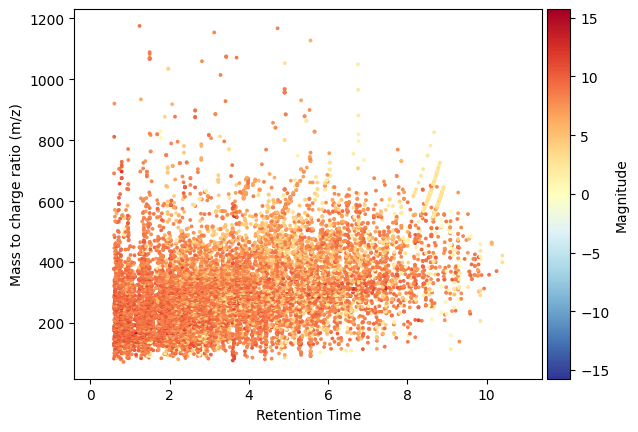

In [11]:
_scatterplots(np.log1p(X).mean(axis=0), xaxis=retention_times, yaxis=mz_values, marker_size=3, alpha=1)

## 1) PCA model fitting

In this tutorial we will fit a PCA model to explore the general trends in the dataset and assess if there are any potential outliers (cause by instrumental issues during data acquisition, for example). We start by describing the model syntax for fitting the PCA models.

### Scaling options and preliminary model fitting

We will start by calculating a series of PCA models with 2 components, each with one of the 3 common scaling choices in chemometrics - mean centring (MC), Unit Variance (UV) and Pareto (Par) scaling. The choice of components to use in the modeling will be addressed properly in the next section.

In [12]:
# Start with log scaling of the data
X = np.log1p(X)

# Select the scaling options:
# Here we are generating 3 scaling objects to explore the effect of scaling in PCA:

# Unit-Variance (UV) scaling:
scaling_object_uv = ChemometricsScaler(scale_power=1)

# Mean Centering (MC):
scaling_object_mc = ChemometricsScaler(scale_power=0)

# Pareto scaling (Par):
scaling_object_par = ChemometricsScaler(scale_power=0.5)

The scaling object will store the vector of column means and standard deviations as it was estimated from the dataset passed to the *fit* method (i.e., during "training" of the classifier).

Pass each scaling object to the PCA method.

In [13]:
# Create and fit the PCA model - starting with UV
PCA_model_uv = ChemometricsPCA(ncomps=2, scaler=scaling_object_uv)
PCA_model_uv.fit(X)

In [14]:
# Create and fit the PCA model - MC
PCA_model_mc = ChemometricsPCA(ncomps=2, scaler=scaling_object_mc)
PCA_model_mc.fit(X)

In [15]:
# Create and fit the PCA model - Par
PCA_model_par = ChemometricsPCA(ncomps=2, scaler=scaling_object_par)
PCA_model_par.fit(X)

### Effect of scaling on PCA Score plots

These plots show the effect that different scaling parameters have on the PCA scores. The scores plots are a usefull summary of the multivariate similarity between samples, and will be used to inspect the main trends in the data.

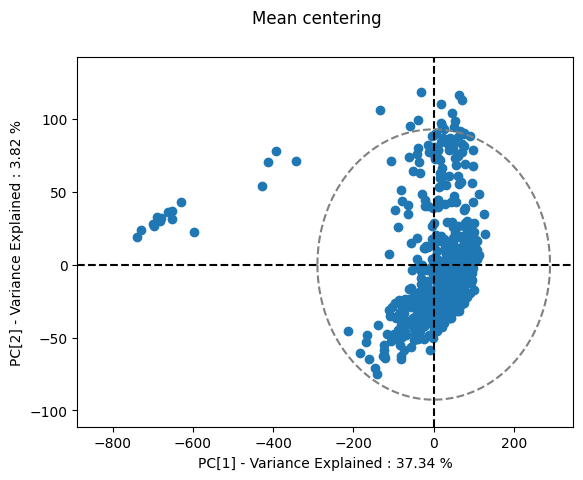

<Axes: xlabel='PC[1] - Variance Explained : 37.34 %', ylabel='PC[2] - Variance Explained : 3.82 %'>

In [16]:
# PCA score plot for the mean centered model
PCA_model_mc.plot_scores(comps=[0, 1], plot_title='Mean centering')


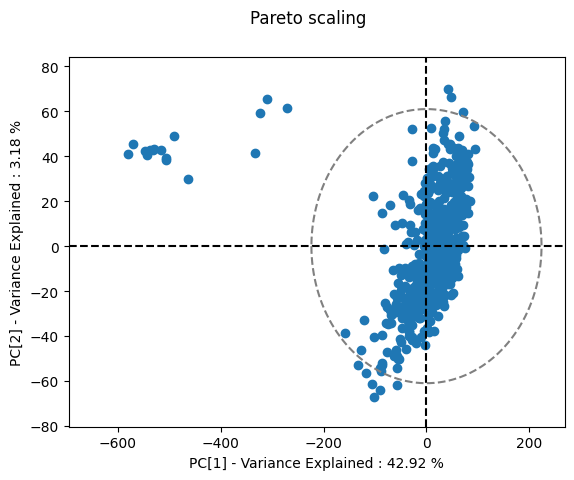

<Axes: xlabel='PC[1] - Variance Explained : 42.92 %', ylabel='PC[2] - Variance Explained : 3.18 %'>

In [17]:
# Score plot for the Pareto scaled model
PCA_model_par.plot_scores(comps=[0, 1], plot_title='Pareto scaling')


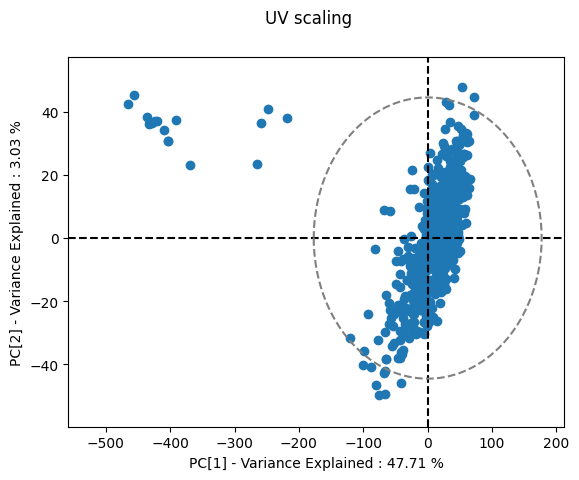

<Axes: xlabel='PC[1] - Variance Explained : 47.71 %', ylabel='PC[2] - Variance Explained : 3.03 %'>

In [18]:
# PCA score plot for UV scaled model
PCA_model_uv.plot_scores(comps=[0, 1], plot_title='UV scaling')


### Effect of scaling on PCA loadings

These plots show the effect that different scaling parameters have on the PCA loadings (also designated as $p$, when refering to a single loading vector or $P$ to the matrix containing the loading vectors for all components).

Although different types of scaling can be used to investigate the structure of the dataset, each type of scaling results in different models, potentially with different interpretations. The *plot_scores* function automatically draws a 95% confidence Hotelling $T^{2}$ ellipse, and flags the points as potential outliers.

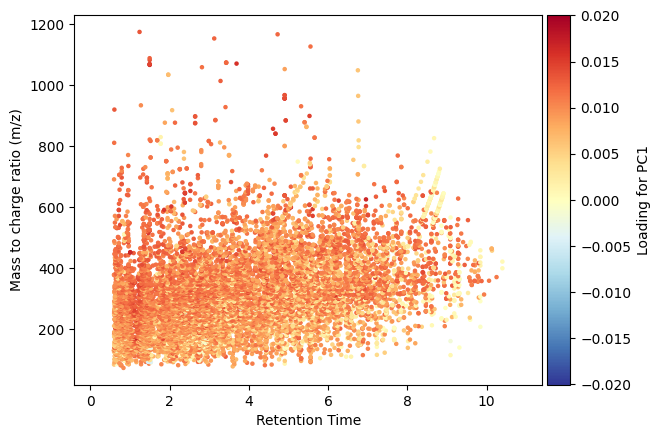

In [19]:
# Plot of first principal component loadings of mean centering model
PCA_model_mc.plot_loadings(ncomp=1,xaxis=retention_times, yaxis=mz_values,instrument='lcms', marker_size=5, alpha = 1)

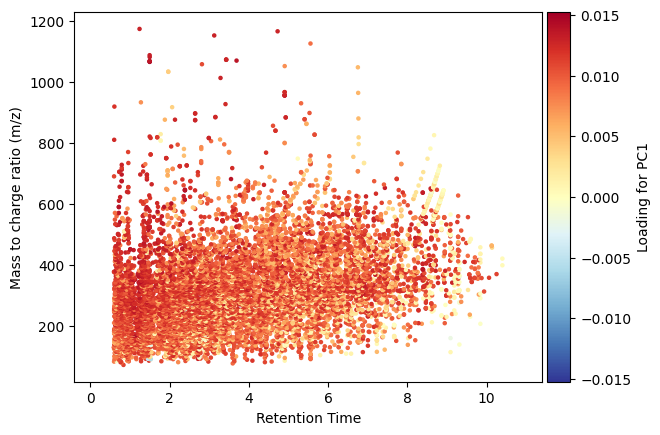

In [20]:
# Plot of first principal component loadings of Pareto scaled model
PCA_model_par.plot_loadings(ncomp=1,xaxis=retention_times, yaxis=mz_values,instrument='lcms', marker_size=5, alpha = 1)

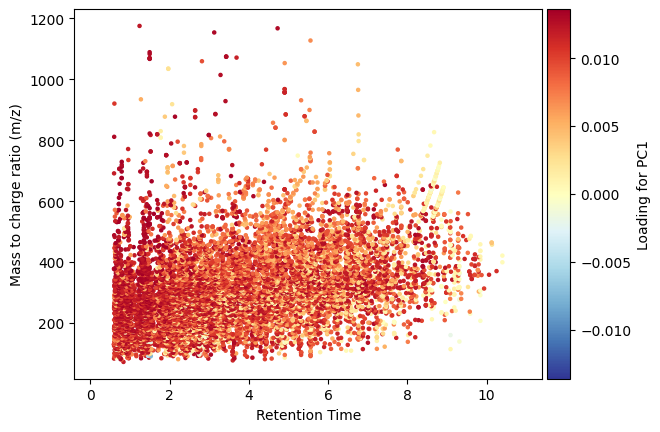

In [21]:
# Plot of first principal component loadings of Unit Variance scaled model
PCA_model_uv.plot_loadings(ncomp=1,xaxis=retention_times, yaxis=mz_values,instrument='lcms', marker_size=5, alpha = 1)

This example highlights the effects of different scaling approaches on PCA scores, loadings, their interpretation and the structure recovered by the model.

We will now proceed with the exploratory analysis of this dataset using UV scaling.

## 2) Model cross-validation and component selection

When generating a PCA model, the number of components is the main parameter that must be chosen.

Ideally, we want to select enough components to capture as much structured variation in the data as possible, but not so  many that random noise starts to be also incorporated in the PCA model.

A sugestion to select the number of components is to use the $Q^{2}X$ measure, and pick the number of components after this metric reaches a plateau (e.g. less than 5% increase compared to previous number of components).

Q2X measure stabilizes (increase of less than 5% of previous value or decrease) at component 2


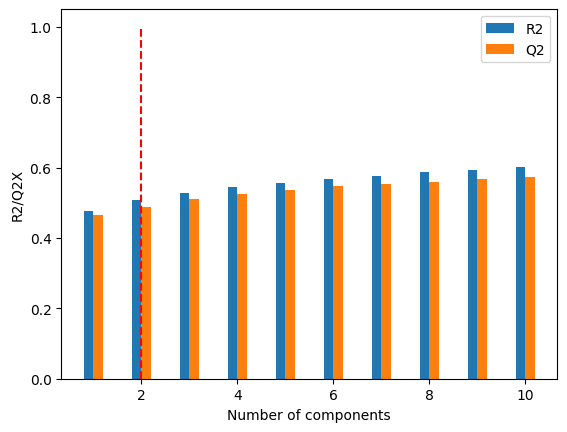

In [22]:
PCA_model_uv.scree_plot(X, total_comps=10)

This suggestion should suffice for exploratory data analysis with PCA. However, the $Q^{2}X$ measure obtained for K-Fold cross validation is sensitive to row permutation of the X matrix. A more robust alternative is to use repeated cross-validation, shuffle the rows in the X matrix each time, and see the distribution of $Q^{2}X$ values per component. This should give a more comprehensive overview of each component's robustness.

**Note**: In an exploratory PCA analysis, the selection of the number of components is not as critical as in a PLS-DA model, and the user can simply select a set of components to explore the data and interactively adjust. Nevertheless, it's still important to benchmark the cross-validated performance of the model, to avoid interpreting or infering biological conclusions from non-robust principal components. **DO NOT RUN THIS PART IN GOOGLE COLABORATORY AS THIS WOULD TAKE UP TO 20 MINUTES TO RUN**

In [ ]:
# # DO NOT RUN IN GOOGLE COLAB
# rep_cv = PCA_model_uv.repeated_cv(X, repeats=5)

Refit the model for further exploration with the selected number of components.

In [23]:
# Create and fit the PCA model - UV scaling
PCA_model_uv = ChemometricsPCA(ncomps=2, scaler=scaling_object_uv)
PCA_model_uv.fit(X)
PCA_model_uv.cross_validation(X)

## 3) Outlier detection and model interpretation

### Outlier detection

PCA can be used to detect potential outliers, and screen samples where a potential problems might have occurred during data acquisition. The main outlier detection tool is the Hotelling $T^{2}$ statistic, a multivariate generalization of the Student's t-distribution. The *plot_scores* function automatically draws a 95% confidence ellipse for $T^{2}$ in the score plot. Samples outside the ellipse are candidate outliers and warrant further investigation.

**Note**: Bear in mind that outlier exclusion can affect the model performance, and therefore every outlier removed during analysis should be justified and always recorded.


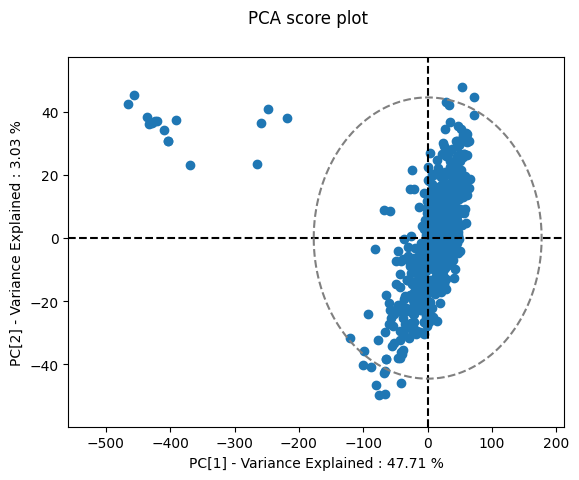

<Axes: xlabel='PC[1] - Variance Explained : 47.71 %', ylabel='PC[2] - Variance Explained : 3.03 %'>

In [24]:
PCA_model_uv.plot_scores(comps=[0, 1])

The PCA score plot highlighted a set of candidate outliers. There is a cluster of 14 main outliers in component 1 and 2.

The *.outlier* function can be used to automatically obtain the indices for candidate outlying samples using all or only a set of selected components. This synthax can be used to obtain outliers matching any given visualization or alongside a single PC component, or to obtain an assessment of which samples are potential outliers using the whole model.

If using Hotelling T2, the significance level can be adjusted to control for the proportion of false positives in outlier detection.

In [25]:
outlier_idx = PCA_model_uv.outlier(X)
print("Outliers for the full 2 component model : {0}".format(outlier_idx))
outlier_idx = PCA_model_uv.outlier(X, comps=[0])
print("Outliers for the 1st principal component : {0}".format(outlier_idx))

Outliers for the full 2 component model : [  6  92 109 122 200 275 280 282 284 286 288 290 292 294 298 300 302 306
 308 310 350 353 381 389 459 467]
Outliers for the 1st principal component : [280 282 284 286 288 290 292 294 298 300 302 306 308 310 350 353]


The next step is to identify the reason for the outlying scores. This can be done by
inspection of the raw data (or a subset of it), analysis of the loading vectors, and by comparing the model predictions/data reconstruction performed by the model.

Text(0.5, 0, 'Feature Index')

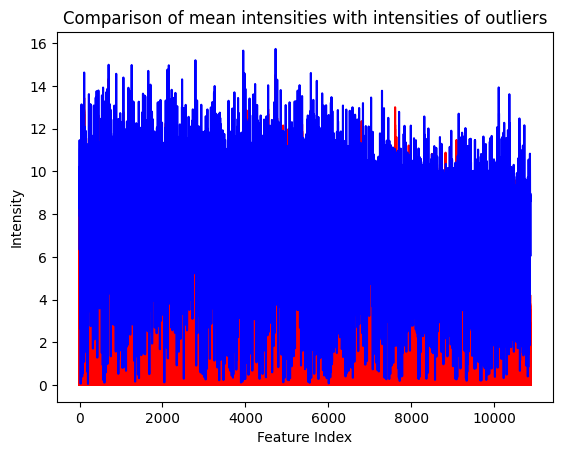

In [26]:
# plot the mean spectrum calculated from the raw data (blue) and the outlying intensity data (red)
plt.figure()
plt.plot( X[outlier_idx, :].T, 'r')
plt.plot( np.mean(X, axis=0), 'b')
plt.gca()
plt.title('Comparison of mean intensities with intensities of outliers')
plt.ylabel('Intensity')
plt.xlabel('Feature Index')

# plt.show()

The PCA score plot should be interpreted using the loading vectors for the corresponding components.

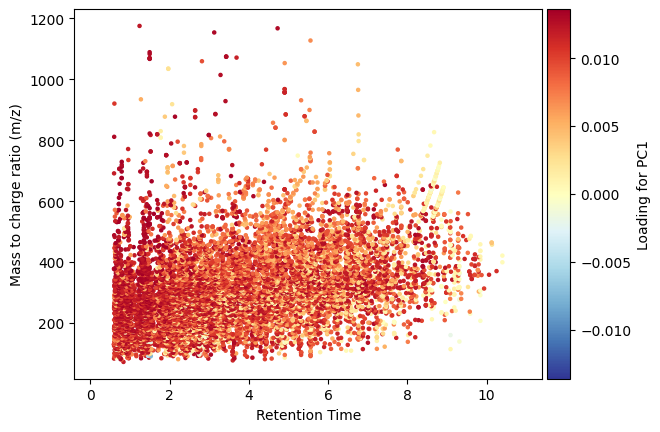

In [27]:
PCA_model_uv.plot_loadings(ncomp=1,xaxis=retention_times, yaxis=mz_values,instrument='lcms', alpha=1)

Direct inspection of the loadings plot obtained from the UV scaled model is not very straightforward...

Another way to investigate outliers is to use score values (from actual samples or artificially created) to generate reconstructed peak intensities. We can explore the PCA model space in this way, and compare peak intensities representative of any desired region of the score plot.

The following plots show the main features, and if an outlier exhibits a value markedly higher than the raw data (depicted in grey), it is visualized in accordance with the colour-bar.

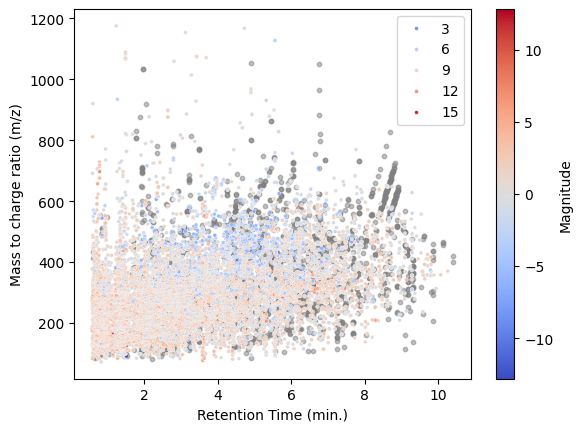

In [28]:
PCA_model_uv.plot_outliers(X, outlier_idx, instrument='lcms', xaxis=retention_times, yaxis=mz_values, sigma = 2)

Another useful measure for outlier detection is the DmodX (Distance to model X) measure. It is calculated based on the model residuals, and can be used to screen for samples which are poorly modelled by the PCA model.
A DmodX plot shows the DmodX value for each sample. Higher values mean more unexplained variation (residual) for that particular sample. An exclusion criterion is delineated by using the F-Statistics to discern if each sample seems to have a higher amount of unexplained variation than overall in the population of samples modelled. F-statistic which assumes Normal distribution of residuals. We also expect 5% of samples beyond the 95% CI.

The DmodX outliers are more useful to decide whether a sample is overall well "explained" by the model. In this case we have quite a few samples above the critical line, but only 19 which seem to be strongly outlying in both DmodX and Hotelling T2.

It is expected that in a variable biological population many observations will contain features not incorporated in a multivariate model fitted on the entire dataset. Adding more principal components could in theory add the residual variability not modelled which is responsible for the DmodX values. In this particular instance we do not take any decision based on the DmodX metric.

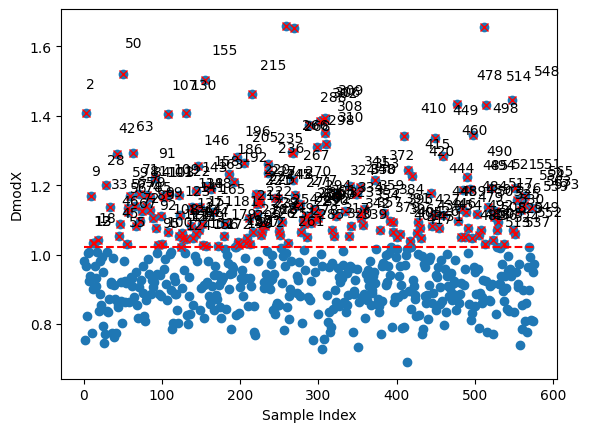

<Axes: xlabel='Sample Index', ylabel='DmodX'>

In [29]:
# The DmodX plot
PCA_model_uv.plot_dmodx(X, label_outliers=True)

In [30]:
# The outlier function can also be used to obtain the DmodX measure and outliers detected with it
outlier_idx = PCA_model_uv.outlier(X, measure='DmodX', alpha=0.05)
print(outlier_idx)

[  2   9  12  13  18  28  33  42  45  46  50  55  56  57  59  63  65  67
  71  72  74  79  81  84  85  89  91  92  95  99 100 101 103 107 108 109
 121 122 123 124 126 127 130 131 137 138 139 141 143 144 146 147 148 151
 152 155 156 158 163 165 172 179 181 186 192 196 197 198 205 207 209 211
 212 215 216 220 221 222 224 225 226 227 228 229 232 235 236 245 248 249
 251 254 259 261 266 267 268 269 270 271 277 278 280 282 284 285 286 288
 290 292 294 297 298 300 301 302 306 308 309 310 317 320 323 324 334 339
 341 342 348 350 353 354 355 357 359 372 379 384 391 395 396 401 405 410
 415 417 420 426 427 430 431 444 446 448 449 454 459 460 478 479 482 484
 485 488 489 490 492 494 496 498 503 505 508 512 513 514 517 521 524 525
 526 529 530 537 548 549 551 552 554 559 563 565 573]


## 4) Model interpretation

We now refit the model without the outliers, and re-assess the findings. The *outlier* method returns the indexes of outlying obersavtions. In the next cell we call it with the *comps* argument = [0], to estimate outliers in the 1st Principal Component.
We seleceted the 1st principal component based on the last scores plot, where the outliers are in the positive value of PC1


In [31]:
outlier_idx = PCA_model_uv.outlier(X, comps=[0])

print("The following samples (row index) have been detected as outliers: {0}".format(outlier_idx))
#Delete the outlier observations (rows)
X_rem = np.delete(X, outlier_idx, axis=0)
Y1_rem = np.delete(Y, outlier_idx, axis=0)
Y2_rem = np.delete(Y2, outlier_idx, axis=0)

The following samples (row index) have been detected as outliers: [280 282 284 286 288 290 292 294 298 300 302 306 308 310 350 353]


After removing outliers, it is recommended to re-assess the model performance using cross validation, and to check whether a model with the same number of components as chosen before is still reliable.

Q2X measure stabilizes (increase of less than 5% of previous value or decrease) at component 4


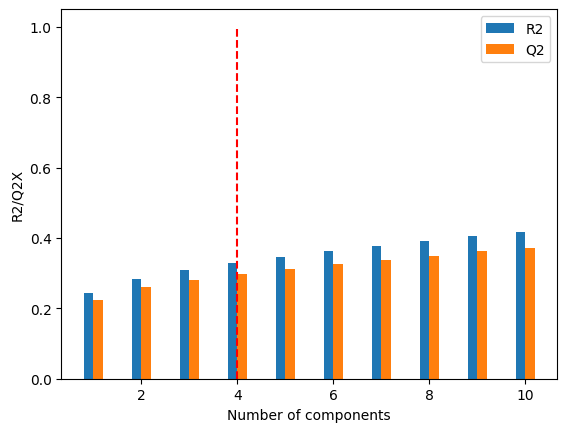

In [32]:
# Create and fit the PCA model - UV scaling
PCA_model_uv = ChemometricsPCA(ncomps=2, scaler=scaling_object_uv)
PCA_model_uv.fit(X_rem)
PCA_model_uv.scree_plot(X_rem, total_comps=10)

In [33]:
# # DO NOT RUN IN GOOGLE COLABORATORY
# rep_cv = PCA_model_uv.repeated_cv(X_rem, repeats=5, total_comps=10)

In [34]:
PCA_model_uv.cross_validation(X_rem)
print("The estimated Q2X from the model is {0}".format(PCA_model_uv.cvParameters['Q2']))

The estimated Q2X from the model is 0.2592547514094683


Applying similar criteria as before, we now refit a PCA model with a total of 4 components.

In [35]:
PCA_model_uv = ChemometricsPCA(ncomps=4, scaler=scaling_object_uv)
PCA_model_uv.fit(X_rem)

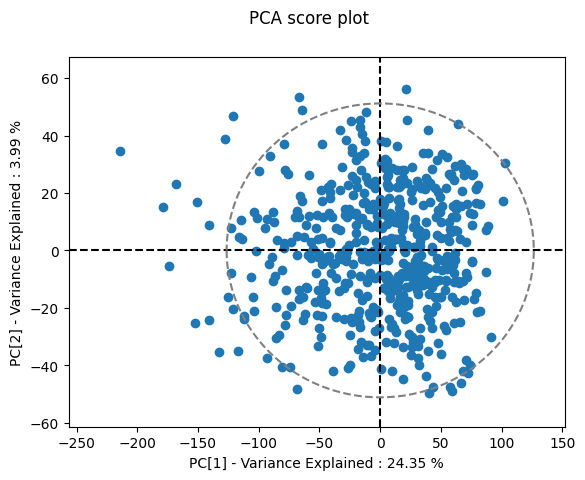

<Axes: xlabel='PC[1] - Variance Explained : 24.35 %', ylabel='PC[2] - Variance Explained : 3.99 %'>

In [36]:
PCA_model_uv.plot_scores()

**Note**: Excluding outliers and re-fitting the model can uncover new candidate outliers. It is not the purpose of this exploratory analysis to obtain a completely *outlier* free dataset for subsequent modelling. We recommend using PCA to screen mainly for large outliers associated with the main Principal components (those who explain a large proportion of the dataset variance) and investigate whether these could be a potential problem in other analyses. If that is the case, further actions might be suggested by the model interpretation, for example, applying some type of batch effect correction or repeating data-preprocessing steps. Although some samples might be outliers due to biological reasons, we do not recommend their automatic exclusion from any further statistical analysis without a strong rationale behind it.

### Exploring the trends in score plots

The *plot_scores* method can use the values of a covariate (discrete or continuous) to colour the scores for each observation. In the next plots we will use the Age and Genotype information to see if there are any biological trends detected in the first PCA components.

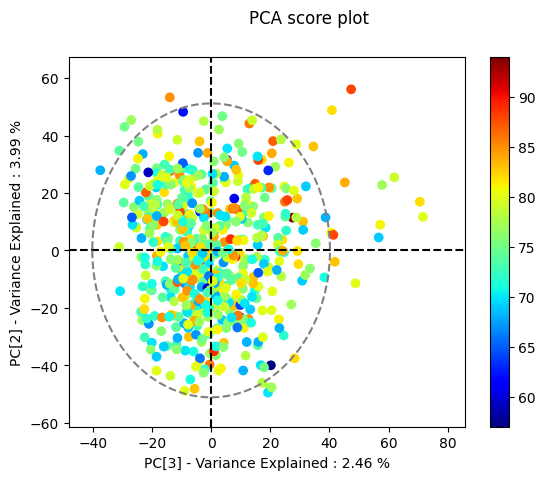

<Axes: xlabel='PC[3] - Variance Explained : 2.46 %', ylabel='PC[2] - Variance Explained : 3.99 %'>

In [37]:
# Age does not seem to be  main driving forces of variation in the dataset, judging from component 2 and 3.
PCA_model_uv.plot_scores(color=Y2_rem, discrete=False, comps=[2, 1])

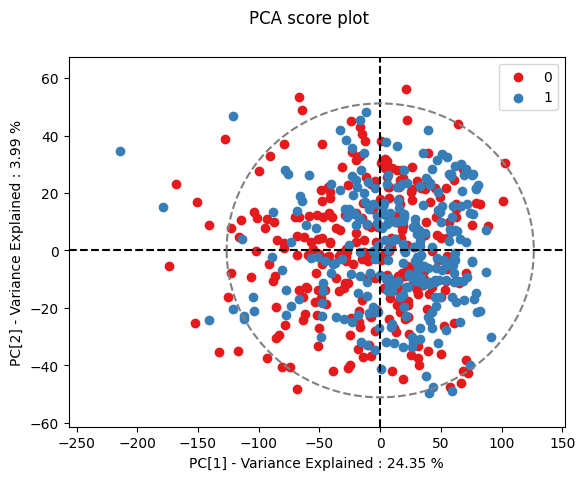

<Axes: xlabel='PC[1] - Variance Explained : 24.35 %', ylabel='PC[2] - Variance Explained : 3.99 %'>

In [38]:
# Age does not seem to have any impact on the biological variation either.
PCA_model_uv.plot_scores(color=Y1_rem, discrete=True, comps=[0, 1])

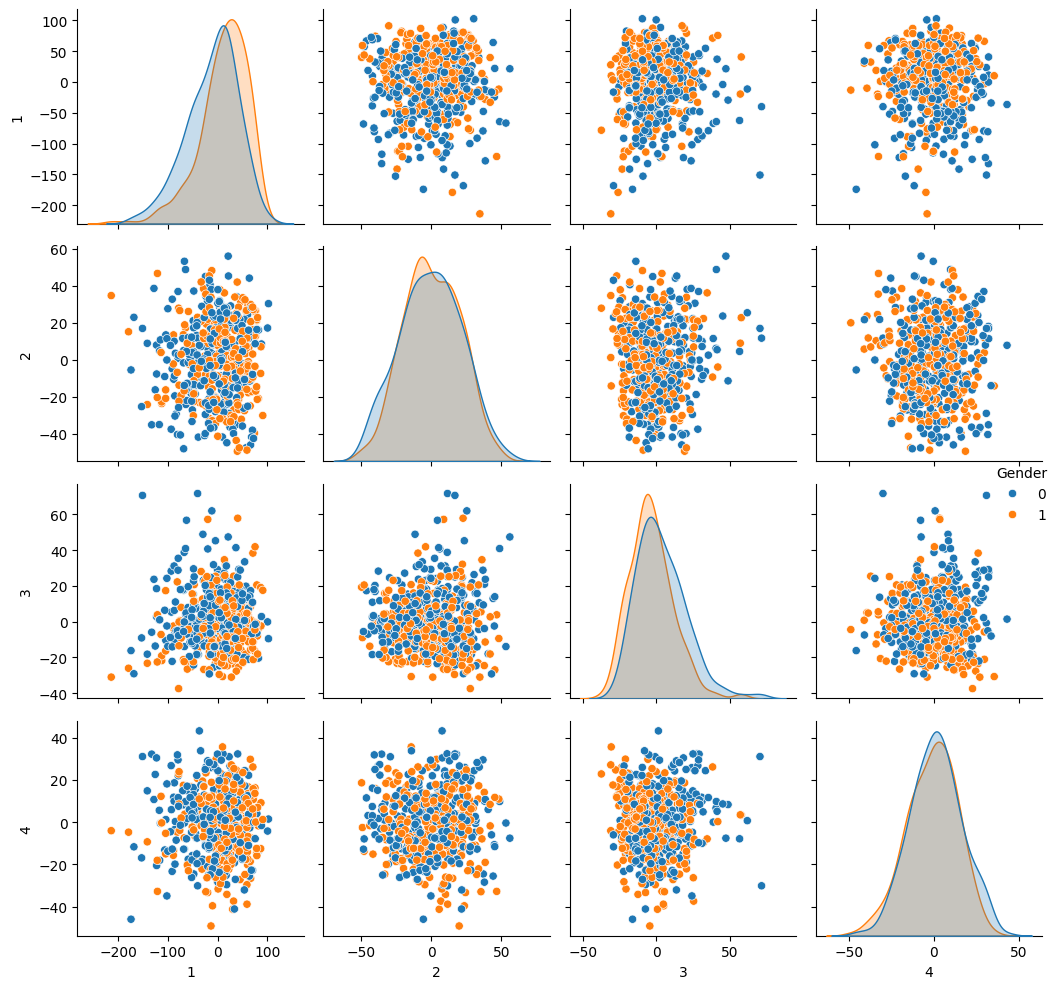

In [39]:
import seaborn as sns
scores_df = pd.DataFrame(PCA_model_uv.scores, columns=range(1, PCA_model_uv.scores.shape[1]+1))
scores_df['Gender'] = Y1_rem
sns.pairplot(
    data=scores_df,
    hue='Gender'
)

plt.xlabel('Component')
plt.ylabel('Component')
plt.tight_layout()
plt.show()

**PCA is a very useful exploratory data analysis tool, especially valuable to visualise the main trends in complex multivariate datasets. It can be very useful for outlier detection and for preliminary data quality assessment and presence of batch or run-order effects.**

**Note**: Always investigate as thoroughly as possible why an observation is an outlier, and record all samples that were excluded from an analysis.



Although it can also be used to investigate biological differences or differences caused by analytical errors, supervised methods are more appropriate for that purpose, because they can specifically measure the "strength" and effect size of metabolome/phenotype associations.

In the next notebook, *Multivariate Analysis - PLS-DA* we will use a supervised model to explicitly investigate metabolic profile differences according to sex, and discuss PLS-DA model interpretation.